_Cuál es la trayectoria actual de incendios en Santa Cruz?_

Construyo un gráfico de incendios diarios acumulados hasta el día de hoy y lo comparo con las series de años pasados. Cómo se compara la situación actual con 2019? En este gráfico utilizo datos del sistema SNPP-VIIRS, que puedes solicitar via [este formulario](https://firms.modaps.eosdis.nasa.gov/download/create.php). Descargué un archivo con datos diarios desde 2012 hasta fines de 2021 y otro con datos al día durante 2022, que en total pesan más de 170 MB.

In [1]:
%%sh
echo "El peso de cada csv que descargué:\n"
du -h data/viirs* | sort -nr

El peso de cada csv que descargué:

168M	data/viirs_historical.csv
5.2M	data/viirs_2022.csv


In [3]:
import datetime as dt
import locale

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from matplotlib import cm, colors, dates, ticker
from scipy.interpolate import pchip

locale.setlocale(locale.LC_TIME, "es_US.UTF8")
plt.style.use("../0_common/estilo.mplstyle");

Estos datos incluyen incendios en toda Bolivia. Para separar sólo aquellos incendios que ocurren en un departamento debo cargar un mapa con límites departamentales. Encuentro uno rápidamente con el [catálogo de datos geográficos](https://mauforonda.github.io/geodatos/) que mantengo, lo simplifico un poco y lo guardo.

In [5]:
DEPARTAMENTOS_GEOBOLIVIA = "https://geo.gob.bo/geoserver/ows?service=WFS&request=GetFeature&typeName=fondos:Departamento_2015&outputFormat=application/json"

departamentos = gpd.read_file(DEPARTAMENTOS_GEOBOLIVIA)
departamentos["geometry"] = departamentos["geometry"].simplify(tolerance=0.01)
departamentos.to_file("datos/departamentos.geojson")

Así en el futuro puedo sólo recargar este mapa:

In [6]:
departamentos = gpd.read_file("data/departamentos.geojson")

Cargo todos los incendios desde 2012 hasta el día de hoy en el mismo sistema de coordenadas de los límites departamentales.

In [7]:
def carga_incendios_csv(csv, crs):
    """
    Carga un csv con incendios como geodataframe con el
    sistema de coordenadas (crs) especificado
    """

    fires = pd.read_csv(csv, low_memory=False)
    fires = gpd.GeoDataFrame(
        fires, geometry=gpd.points_from_xy(fires.longitude, fires.latitude), crs=crs
    )
    fires["acq_date"] = pd.to_datetime(fires.acq_date, format="%Y-%m-%d")
    return fires

In [8]:
incendios = pd.concat(
    [
        carga_incendios_csv("data/{}.csv".format(f), departamentos.crs)
        for f in ["viirs_historical", "viirs_2022"]
    ]
)

In [9]:
display(
    Markdown(
        "Existen {} incendios detectados y cada registro tiene esta forma:".format(
            len(incendios)
        )
    )
)
incendios.sample(1)

Existen 2193869 incendios detectados y cada registro tiene esta forma:

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type,geometry,brightness,bright_t31
967610,-12.440424,-66.413048,345.49,0.47,0.4,2017-12-22,1811,N,VIIRS,n,1,295.72,9.27,D,0.0,POINT (-66.41305 -12.44042),NaN,NaN


Puedes encontrar una descripción de cada campo [acá](https://www.earthdata.nasa.gov/learn/find-data/near-real-time/firms/viirs-i-band-375-m-active-fire-data).

Podría filtrar incendios dentro de cualquier departamento

In [129]:
Markdown(
    "_Departamentos_: "
    + ", ".join(
        departamentos[departamentos.DESCRIPCIO == "Departamento"].DEPARTAMEN.tolist()
    )
)

_Departamentos_: Cochabamba, Potosí, Chuquisaca, Tarija, Santa Cruz, Pando, Oruro, Beni, La Paz

En este caso selecciono Santa Cruz

In [10]:
def filter_incendios(departamento):

    return gpd.sjoin(
        incendios,
        departamentos[departamentos.DEPARTAMEN == departamento],
        how="inner",
        predicate="within",
    )

In [11]:
santacruz = filter_incendios("Santa Cruz")

Construyo una tabla con el número diario de incendios en Santa Cruz para cada día, y una columna para cada año para realizar gráficos y comparaciones fácilmente. En este caso utilizo todos los incendios detectados, pero podría seleccionar sólo aquellos sobre un nivel de confianza o cualquier otro criterio utilizando los campos disponibles.

In [12]:
def daily_fires(incendios_dataframe):
    """
    Agrupa incendios por día y crea una columna para cada año.
    """

    incendios_dataframe["year"] = incendios_dataframe.acq_date.dt.year
    incendios_dataframe["date"] = [
        d.replace(year=2000) for d in incendios_dataframe.acq_date
    ]
    incendios_diarios = (
        incendios_dataframe.groupby(
            ["date", "year", pd.Grouper(key="acq_date", freq="D")]
        )
        .size()
        .reset_index(name="incendios")
    )

    incendios_diarios = incendios_diarios.pivot_table(
        index="date", columns="year", values="incendios"
    )

    current_year = incendios_dataframe.year.max()
    other_years = [
        col
        for col in incendios_diarios.columns
        if col != incendios_dataframe.year.max()
    ]
    last_date = incendios_dataframe.acq_date.max().replace(year=2000)

    incendios_diarios = pd.concat(
        [
            incendios_diarios[other_years].fillna(0),
            incendios_diarios.loc[:last_date, current_year].fillna(0),
        ],
        axis=1,
    )

    return incendios_diarios

In [13]:
santacruz_diario = daily_fires(santacruz)

In [14]:
santacruz_diario

,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
date,,,,,,,,,,,
2000-01-01,0.0,14.0,38.0,146.0,8.0,89.0,1.0,32.0,11.0,7.0,40.0
2000-01-02,0.0,0.0,41.0,44.0,6.0,43.0,2.0,36.0,8.0,125.0,52.0
2000-01-03,0.0,7.0,72.0,0.0,25.0,101.0,0.0,120.0,59.0,268.0,97.0
2000-01-04,0.0,41.0,4.0,9.0,13.0,192.0,8.0,38.0,213.0,53.0,126.0
2000-01-05,0.0,31.0,0.0,27.0,140.0,156.0,11.0,140.0,199.0,78.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...
2000-12-27,5.0,90.0,50.0,28.0,9.0,33.0,36.0,64.0,40.0,27.0,NaN
2000-12-28,0.0,78.0,78.0,82.0,2.0,48.0,107.0,46.0,32.0,99.0,NaN
2000-12-29,15.0,38.0,44.0,220.0,69.0,5.0,56.0,108.0,71.0,121.0,NaN


Finalmente construyo un gráfico con una línea para cada año. Cada elemento y transformación está comentada para dar una idea del proceso. Al diseñar esta función intento encontrar un balance entre parametrizar atributos que de otra forma parecerían demasiado arbitrarios y tener algo que pueda ser usado fácilmente en otra ocasión.

In [15]:
def plot_incendios(
    diarios,
    departamento_nombre='Santa Cruz',
    filename=None,
    last_day=None,
    credits={'datos': 'SNPP - VIIRS', 'diseño': 'Mauricio Foronda'},
    cmap=colors.ListedColormap(cm.get_cmap("viridis")(np.linspace(0.2, 1.0, 255))),
    background="#0f283a",
    gridcolor="#4e6879",
    lightcolor="#e9e4cd",
    flamecolor="#ac321a",
):
    def smooth_dateline(serie, num=300):
        """
        Suaviza una serie, en tanto mayor sea `num`,
        más suave la línea.
        """
        s = serie.dropna()
        x_num = dates.date2num(s.index)
        x_smooth = np.linspace(x_num.min(), x_num.max(), num)
        spline = pchip(x_num, s)
        y_smooth = spline(x_smooth)
        return pd.Series(y_smooth, index=x_smooth)

    def spaced_annotations(yearend, min_spacing=8):
        """
        Resuelve casos donde las anotaciones de años
        se sobrelapan entre sí. `min_spacing` es el mínimo
        espacio vertical que debería existir entre anotaciones.
        """
        solved = []
        final_values = []
        for value, nextvalue in zip(yearend, yearend[1:]):
            if value not in solved:
                spacing = nextvalue - value
                if spacing < min_spacing:
                    extra_space = (min_spacing - spacing) / 2
                    final_values.extend([value - extra_space, nextvalue + extra_space])
                    solved.extend([value, nextvalue])
                else:
                    final_values.append(value)
                    solved.append(value)
        final_series = pd.Series(
            final_values + [yearend.tolist()[-1]], index=yearend.index
        ).to_dict()
        return final_series

    # la suma acumulativa dividida entre mil
    dcum = diarios.cumsum() / 1e3

    # inicializo la figura y pinto el color de fondo
    f, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
    for i in [f, ax]:
        i.set_facecolor(background)

    # defino algunas variables útiles
    n_years = len(dcum.columns) # el número de años
    current_year = dcum.columns[-1] # el último año
    ax_border = dt.date(2001, 1, 2) # el borde derecho de la figura
    annotation_positions = spaced_annotations(dcum.iloc[:, :-1].tail(1).iloc[0].sort_values()) # las posiciones verticales de las anotaciones de año

    # dibujar la línea para cada año
    for i, year in enumerate(dcum.columns):
        if year != current_year:
            # definir la opacidad de la línea según cuán próxima sea al último año,
            # en tanto más próxima, más clara
            alpha = (i + 1) / (n_years + 3)
        else:
            # si se trata del último año, dibujar la línea más clara
            # además almacenar la última fecha y valor para posicionar otras figuras
            last_date, last_value = dcum[year].dropna().tail(1).reset_index().values[0]
            alpha = 1.0
        color = colors.to_hex(cmap(alpha)) # el color es el valor de la opacidad en el mapa de colores
        smooth_year = smooth_dateline(dcum[year]) # suavizar la serie del año
        ax.plot(smooth_year, color=color, linewidth=0.8, alpha=alpha) # dibujar la figura suavizada

        # si se trata del año actual crear otras figuras encima
        # que hagan brillar a esta línea
        if year == current_year:
            # una línea casi transparente
            ax.plot(smooth_year, color=lightcolor, linewidth=1.2, alpha=0.2)
            # tres puntos que hagan una punta incandescente
            for dotcolor, dotsize, dotalpha in zip(
                [lightcolor, flamecolor, lightcolor], [40, 25, 15], [0.1, 0.3, 1.0]
            ):
                ax.scatter(
                    [last_date],
                    [last_value],
                    color=dotcolor,
                    alpha=dotalpha,
                    s=dotsize,
                    linewidth=0,
                )

        # si no es el último año dibujar una anotación al final de la serie
        if year != current_year:
            annotation_x = ax_border
            annotation_y = annotation_positions[year]
            annotation_text = year
            ha = "left"
            annotation_color = color
        # si es el último año dibujar una anotación encima del último valor
        else:
            last_date = dcum[year].dropna().index[-1]
            annotation_x = last_date
            annotation_y = last_value + 20
            if last_day == None:
                annotation_text = last_date.replace(year=year).strftime(
                    "%d de %B\nde %Y"
                )
            else:
                annotation_text = last_day
            ha = "right"
            annotation_color = lightcolor

        ax.annotate(
            annotation_text,
            xy=(annotation_x, annotation_y),
            ha=ha,
            va="center",
            color=annotation_color,
            fontsize=6,
        )

    # parámetros para los ticks, la reja y los límites horizontales
    ax.tick_params(labelsize=5)
    ax.xaxis.set_major_locator(dates.MonthLocator(bymonthday=15))
    ax.xaxis.set_major_formatter(dates.DateFormatter("%B"))
    ax.grid(color=gridcolor, axis="y")
    ax.set_xlim(dt.date(2000, 1, 1), dt.date(2001, 1, 2))
    
    # dibujar el título y los créditos
    # comenzar desde `top_title` y bajar `margin_title` con cada texto
    
    top_title = 271
    margin_title = 7
    margin_credit = 4
    
    for text, fontsize in zip(['incendios', 'cumulativos', 'en {}'.format(departamento_nombre)], [23, 14, 23]):
        annotation = ax.annotate(text.upper(), xy=(dt.datetime(2000,1,20), top_title), fontweight='bold', fontsize=fontsize, ha='left', va='top', color=lightcolor)
        annotation_coords = ax.transData.inverted().transform(annotation.get_window_extent(renderer=f.canvas.get_renderer()))
        top_title = annotation_coords[0][1] - margin_title
        
    # luego bajar 8 y hacer lo mismo para los créditos
    # pero en lugar de `margin_title`, usar `margin_credit` para espaciar
    # verticalmente textos
    
    top_title -= 8
    
    for cred in credits.keys():
        annotation = ax.annotate(cred, xy=(dt.datetime(2000,1,20), top_title), fontsize=7, ha='left', va='top', color=lightcolor)
        annotation_coords = ax.transData.inverted().transform(annotation.get_window_extent(renderer=f.canvas.get_renderer()))
        ax.annotate(credits[cred], xy=(annotation_coords[1][0] + 3, top_title), fontsize=7, ha='left', va='top', color=lightcolor, fontweight='bold')
        top_title = annotation_coords[0][1] - margin_credit

    # algunos ajustes finales para ticks en el eje vertical
    # quitar el 0 abajo y poner un `mil` al lado del
    # último tick superior
    
    f.canvas.draw()
    labels = ax.get_yticklabels()
    labels =[i.get_text() for i in labels]
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(['', ''] + labels[2:-1] + [''])
    ax.set_ylim(bottom=-0.5)
    
    last_ytick = ax.get_yticks()[-2]
    ax.annotate('mil', xy=(dt.datetime(2000,1,1), last_ytick - 3), fontsize=5, ha='right', va='bottom', color='#88888f')
       
    # finalmente, guardar todo en el `filename` que especifico, si existe alguno
    if filename != None:
        f.savefig(
            "plots/{}".format(filename), bbox_inches="tight", pad_inches=0.2, dpi=300
        )

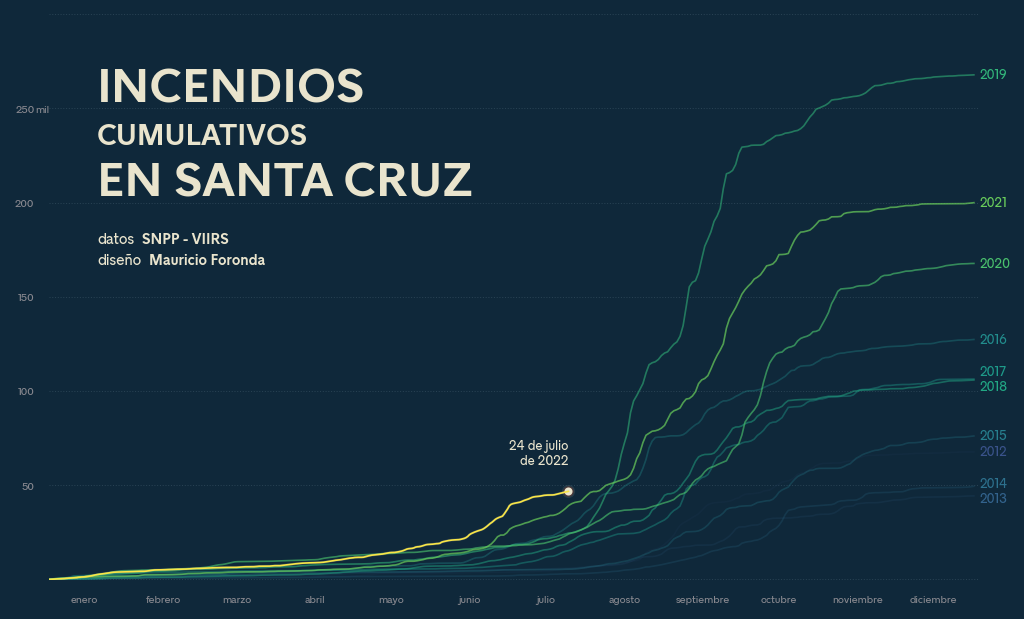

In [16]:
plot_incendios(santacruz_diario)

Para suavizar cada línea mejor podría agrupar el número de incendios por semana:

In [22]:
santacruz_semanal = (
    santacruz_diario.reset_index()
    .groupby(pd.Grouper(key="date", freq="W-MON"))
    .sum()
    .replace(0, np.nan)
)

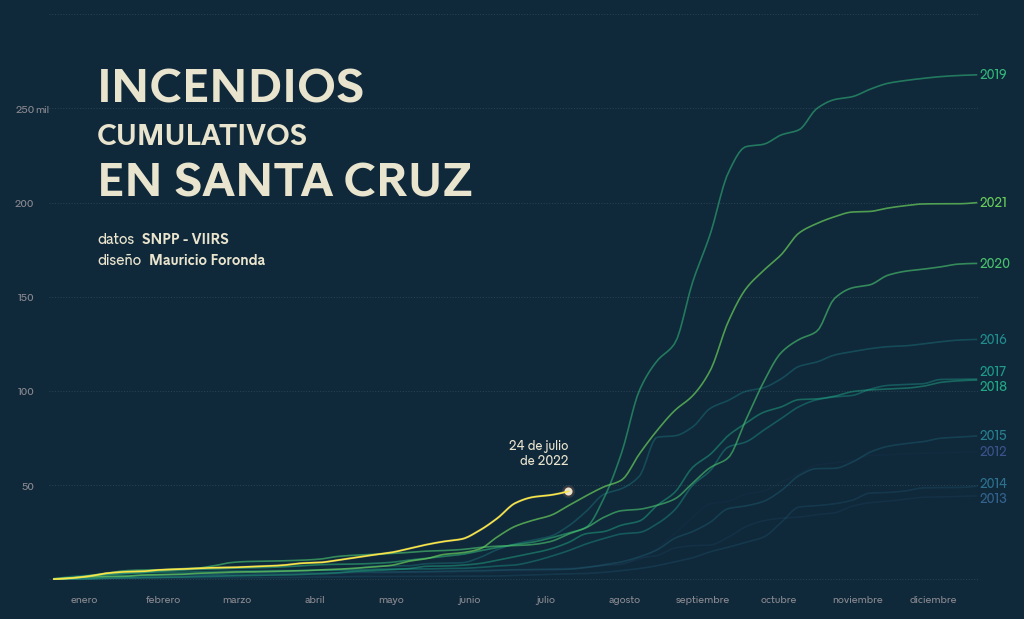

In [25]:
plot_incendios(santacruz_semanal, last_day="24 de julio\nde 2022", filename='incendios_santacruz_semanal.png')

Me gusta más esta versión con líneas suavizadas por el aspecto orgánico que ganan en esta paleta de colores. Casi como un niño corriendo sin control con una tenaza incandescente a mitad de una selva. Elegante y encantador, pero en tensión.

Este gráfico puede ser reproducido inmediatamente con datos nuevos, otro departamento, otra paleta de colores o un texto distinto.